Epoch [10/100], Loss: 1.1904
Epoch [20/100], Loss: 1.1804
Epoch [30/100], Loss: 1.1746
Epoch [40/100], Loss: 1.1728
Epoch [50/100], Loss: 1.1733
Epoch [60/100], Loss: 1.1738
Epoch [70/100], Loss: 1.1738
Epoch [80/100], Loss: 1.1742
Epoch [90/100], Loss: 1.1718
Epoch [100/100], Loss: 1.1726

Name: SANJITH R
Reg No: 212223230191

Test Accuracy: 47.12%
Classification Report:
               precision    recall  f1-score   support

           A       0.38      0.52      0.44       853
           B       0.43      0.14      0.22       760
           C       0.47      0.55      0.51       699
           D       0.59      0.64      0.61       897

    accuracy                           0.47      3209
   macro avg       0.47      0.46      0.44      3209
weighted avg       0.47      0.47      0.45      3209



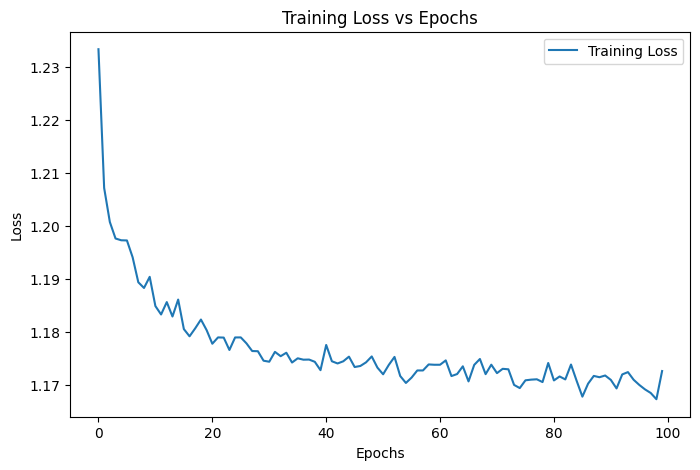

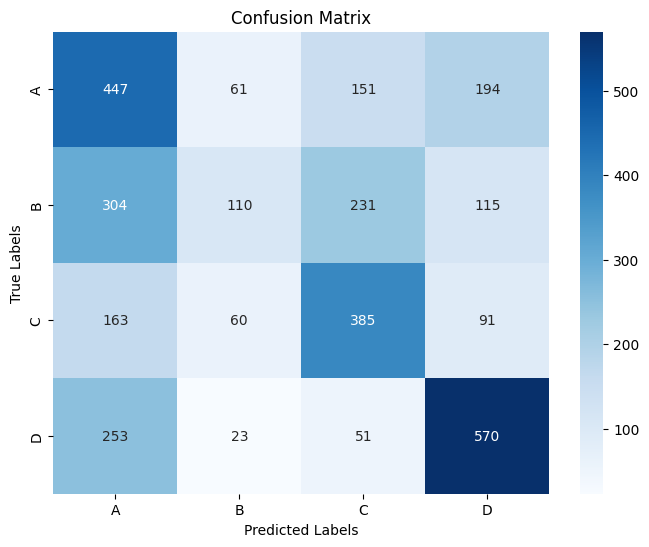


Predicted class for sample input: D
Actual class for sample input: D


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Dataset ---
# Make sure 'customers.csv' is in your Colab files
data = pd.read_csv("/content/customers.csv")

# --- 2. Data Preprocessing ---
# Drop ID column as it's not useful for classification
data = data.drop(columns=["ID"])

# Handle missing values
data.fillna({"Work_Experience": 0, "Family_Size": data["Family_Size"].median()}, inplace=True)

# Encode categorical variables
categorical_columns = ["Gender", "Ever_Married", "Graduated", "Profession", "Spending_Score", "Var_1"]
for col in categorical_columns:
    data[col] = LabelEncoder().fit_transform(data[col])

# Encode target variable (Segmentation: A, B, C, D -> 0, 1, 2, 3)
label_encoder = LabelEncoder()
data["Segmentation"] = label_encoder.fit_transform(data["Segmentation"])

# Split features and target
X = data.drop(columns=["Segmentation"]).values
y = data["Segmentation"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# --- 3. Neural Network Architecture ---
class PeopleClassifier(nn.Module):
    def __init__(self, input_size):
        super(PeopleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 4)  # 4 output classes (A, B, C, D)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation needed here, CrossEntropyLoss applies Softmax internally
        return x

# Initialize Model
model = PeopleClassifier(input_size=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# --- 4. Training Loop ---
loss_history = []

def train_model(model, train_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Average loss for the epoch
        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

# Train for 100 Epochs
train_model(model, train_loader, criterion, optimizer, epochs=100)

# --- 5. Evaluation ---
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())
        actuals.extend(y_batch.numpy())

# Compute metrics
accuracy = accuracy_score(actuals, predictions) * 100
conf_matrix = confusion_matrix(actuals, predictions)
class_report = classification_report(actuals, predictions, target_names=[str(i) for i in label_encoder.classes_])

print("\n" + "="*30)
print("Name: SANJITH R")
print("Reg No: 212223230191")
print("="*30)

print(f'\nTest Accuracy: {accuracy:.2f}%')
print("Classification Report:\n", class_report)

# --- 6. Plots ---

# Plot 1: Training Loss (Added for you)
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Training Loss')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot 2: Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, fmt='g')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# --- 7. Prediction for a sample input ---
sample_input = X_test_tensor[12].clone().unsqueeze(0).detach().type(torch.float32)
with torch.no_grad():
    output = model(sample_input)
    predicted_class_index = torch.argmax(output[0]).item()
    predicted_class_label = label_encoder.inverse_transform([predicted_class_index])[0]
    actual_class_label = label_encoder.inverse_transform([y_test_tensor[12].item()])[0]

print(f'\nPredicted class for sample input: {predicted_class_label}')
print(f'Actual class for sample input: {actual_class_label}')